

## 1. PCA-режим

**Теория (шаги):**

1. Применяем PCA к исходным данным, получаем 2-мерные признаки $z_i$.
2. Строим «мягкое» соседство в PCA-пространстве:

   $$
     p(j|i) = \frac{\exp\bigl(-\|z_i - z_j\|^2 / (2\sigma^2)\bigr)}{\sum_k \exp\bigl(-\|z_i - z_k\|^2 / (2\sigma^2)\bigr)}.
   $$

3. Делаем α-дебиасинг:

   $$
     \tilde{p}(j|i) = (1-\alpha) \cdot p(j|i) + \frac{\alpha}{N}.
   $$

4. Инициализируем энкодер, получаем модельное распределение:

   $$
     q(j|i) = \mathrm{softmax}\bigl(-\|h_i - h_j\|^2/(2\sigma^2)\bigr)
   $$

5. Обучаем энкодер, минимизируя:
   
   $$
   {L}_{I-CON}=\sum_i D_{KL}\bigl(\tilde{p}(\cdot|i),q(\cdot|i)\bigr)
   $$

**Анализ графиков:**

**Шаг 1: Глобальная матрица $p(j|i)$ (часть)**

* Смотрим на (1).png
* По горизонтали и вертикали — индексы точек.
* Яркие квадраты на диагонали: точки одного «истинного» кластера имеют высокую похожесть.
* Тёмные области вне диагонали: между кластерами вероятность соседства низкая.

**Шаг 2: Сравнение $p$ и $\tilde{p}$**

* Смотрим на (2).png
* **Синяя гистограмма**: исходное $p$ варьируется примерно от 0.01 до 0.05.
* **Оранжевая**: после α-дебиасинга все значения смещаются ближе к $1/N\approx0.01$, но края «пиков» сохраняют небольшую высоту.

**Шаг 3: $Q$ до обучения (часть)**

* Смотрим на (3).png
* Модель $q$ при случайных весах даёт почти «шумную» матрицу без чётких блоков: энкодер ещё не обучен отражать соседство из $p$.

**Шаг 4: Кривые KL loss при обучении**

* Смотрим на (4).png
* Начальное значение ${L}=0.48$.
* Быстрый спад до $\approx0.15$ к 20-й эпохе.
* Плавное снижение до финальных $\approx0.07$ к 100-й эпохе.
* Это явный признак того, что $q$ приближается к $\tilde{p}$.

**Шаг 5: $Q$ после обучения (часть)**

* Смотрим на (5).png
* Чётко проявились блоки высокой вероятности там же, где в исходном $p$.
* Энкодер научился «ощущать» локальную структуру PCA-пространства.

**Шаг 6: Представления $h$ после обучения**

* Смотрим на (6).png
* В 2D-пространстве $h$ образовались четыре хорошо разделённых облака.
* Точки одного кластера сблизились, кластеры разошлись — линейная разделимость достигнута.

## 2. k-means-режим

**Теория (шаги):**

1. С помощью k-means получаем жёсткие назначения:

   $$
     p(j|i)=
     \begin{cases}
       1, &\text{если }i\text{ в кластере }j,\\
       0, &\text{иначе.}
     \end{cases}
   $$

2. Сглаживаем тем же α-дебиасингом:
   
   $$\tilde{p}=(1-\alpha)p+\alpha/k$$

3. Энкодер выдаёт:
   
   $$q(j|i)=\mathrm{softmax}\bigl(-\|h_i - c_j\|^2/(2\sigma^2)\bigr)$$
   
   где $c_j$ — центр $j$-го кластера (фиксирован).

4. Обучаем энкодер, минимизируя
   
   $$\sum_i D_{KL}(\tilde{p}(\cdot|i)|q(\cdot|i))$$

**Анализ графиков:**

**Шаг 1: One-hot $p(j|i)$ (часть)**

* Смотрим на (7).png
* Каждый ряд имеет одну «жёлтую» единицу: точка принадлежит ровно одному кластеру.

**Шаг 2: Сравнение $p$ и $\tilde{p}$**

* Смотрим на (8).png
* Исходно значения 0 или 1.
* После сглаживания пики смещаются к $(1-\alpha)+\alpha/k\approx0.85$ и к $\alpha/k\approx0.05$.

**Шаг 3: $Q$ до обучения (часть)**

* Смотрим на (9).png
* Энкодер ещё не «понимает» кластеризацию: вероятности распределены без явной one-hot-структуры.

**Шаг 4: Представления $h$ после обучения**

* Смотрим на (10).png
* После оптимизации энкодер выстроил точки в четырёх чётких кластерах, повторив результаты PCA-режима, но опираясь на жёсткие назначения k-means.

## Итог по I-CON

1. **Унификация.** В обоих режимах цель одна — свести модельное распределение $q$ к эталонному $\tilde{p}$ через KL-дивергенцию.

2. **Сглаживание.** α-дебиасинг обеспечивает устойчивость, избегая «переуверенности».

3. **Гибкость.** Разные $p$ (гауссово соседство или one-hot k-means) приводят к разным способам формализации задачи, но подходят под одну формулу.

4. **Эффективность.** Наблюдаем быстрое снижение KL-лосса и появление чётко разделённых представлений.

In [4]:
"""
Визуализация и анализ снижения размерности методами PCA и t-SNE

Данный скрипт демонстрирует процесс снижения размерности многомерных данных
с использованием PCA и обучаемого энкодера, оптимизирующего KL-дивергенцию между
распределениями вероятностей в исходном и сниженном пространствах.
Дополнительно представлен режим кластеризации с использованием k-means.

Основные этапы работы:
1. Генерация синтетических данных с использованием make_blobs
2. Применение PCA для снижения размерности до 2D
3. Расчет матрицы условных вероятностей p(j|i) в пространстве PCA
4. Применение α-дебиасинга для матрицы вероятностей
5. Обучение нейросетевого энкодера для получения низкоразмерных представлений
6. Сравнение и визуализация результатов
7. Дополнительный режим с использованием k-means
"""

# Стандартные библиотеки Python
from typing import Tuple

# Библиотеки для научных вычислений
import numpy as np

# Библиотеки глубокого обучения PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Библиотеки машинного обучения scikit-learn
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Библиотеки для визуализации
import matplotlib.pyplot as plt

In [5]:
class Encoder(nn.Module):
    """
    Description:
    ---------------
        Простой линейный энкодер для снижения размерности.

    Args:
    ---------------
        in_dim: Размерность входных данных
        out_dim: Размерность выходных данных (сниженная размерность)

    Returns:
    ---------------
        Тензор сниженной размерности
    """
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Прямой проход через линейный слой.

        Args:
        ---------------
            x: Входной тензор размерности [batch_size, in_dim]

        Returns:
        ---------------
            Выходной тензор размерности [batch_size, out_dim]
        """
        return self.linear(x)

In [6]:
def generate_data(n_samples: int, dimensions: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Description:
    ---------------
        Генерирует синтетические данные с использованием make_blobs и стандартизирует их.

    Args:
    ---------------
        n_samples: Количество точек данных
        dimensions: Размерность данных

    Returns:
    ---------------
        Кортеж (X, y), где X - стандартизированные данные, y - метки кластеров
    """
    X, y = make_blobs(n_samples=n_samples, centers=4, n_features=dimensions, random_state=42)
    X = StandardScaler().fit_transform(X)
    return X, y

In [7]:
def apply_pca(X: np.ndarray, n_components: int = 2) -> np.ndarray:
    """
    Description:
    ---------------
        Применяет PCA для снижения размерности данных.

    Args:
    ---------------
        X: Исходные данные размерности [n_samples, n_features]
        n_components: Количество главных компонент

    Returns:
    ---------------
        Преобразованные данные размерности [n_samples, n_components]
    """
    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(X)
    return Z

def compute_probability_matrix(Z: np.ndarray, sigma: float) -> np.ndarray:
    """
    Description:
    ---------------
        Вычисляет матрицу условных вероятностей p(j|i) на основе
        квадратов евклидовых расстояний между точками.

    Args:
    ---------------
        Z: Данные в сниженном пространстве размерности [n_samples, n_components]
        sigma: Параметр ширины гауссова ядра

    Returns:
    ---------------
        Матрица вероятностей P размерности [n_samples, n_samples]
    """
    # Вычисление квадратов расстояний между всеми парами точек
    sqdist = np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=2)

    # Преобразование расстояний в вероятности через гауссово ядро
    P = np.exp(-sqdist / (2 * sigma**2))

    # Нормализация по строкам
    P /= P.sum(axis=1, keepdims=True)

    return P

def apply_debiasing(P: np.ndarray, alpha: float, n_samples: int) -> np.ndarray:
    """
    Description:
    ---------------
        Применяет α-дебиасинг к матрице вероятностей.

    Args:
    ---------------
        P: Исходная матрица вероятностей
        alpha: Коэффициент дебиасинга
        n_samples: Количество точек данных

    Returns:
    ---------------
        Дебиасированная матрица вероятностей
    """
    return (1 - alpha) * P + alpha / n_samples

In [8]:
def compute_Q(h: torch.Tensor, sigma: float) -> torch.Tensor:
    """
    Description:
    ---------------
        Вычисляет матрицу вероятностей Q на основе представлений h.

    Args:
    ---------------
        h: Представления размерности [n_samples, out_dim]
        sigma: Параметр ширины гауссова ядра

    Returns:
    ---------------
        Матрица вероятностей Q размерности [n_samples, n_samples]
    """
    dist2 = torch.sum((h[:, None, :] - h[None, :, :])**2, dim=2)
    return torch.softmax(-dist2 / (2 * sigma**2), dim=1)

def kl_loss(P_np: np.ndarray, Q_t: torch.Tensor, device: str) -> torch.Tensor:
    """
    Description:
    ---------------
        Вычисляет KL-дивергенцию между матрицами P и Q.

    Args:
    ---------------
        P_np: Матрица вероятностей P (numpy)
        Q_t: Матрица вероятностей Q (torch)
        device: Устройство для вычислений ('cpu' или 'cuda')

    Returns:
    ---------------
        Значение KL-дивергенции

    Examples:
    ---------------
        >>> P = np.random.rand(10, 10)
        >>> P /= P.sum(axis=1, keepdims=True)
        >>> Q = torch.rand(10, 10)
        >>> Q = torch.softmax(Q, dim=1)
        >>> loss = kl_loss(P, Q, 'cpu')
    """
    P_t = torch.tensor(P_np, device=device)
    Q_safe = Q_t + 1e-12  # Добавляем малое значение для численной стабильности
    kl = P_t * (torch.log(P_t) - torch.log(Q_safe))
    return torch.mean(torch.sum(kl, dim=1))

In [9]:
def train_encoder(
    X_tensor: torch.Tensor,
    model: nn.Module,
    P_debias: np.ndarray,
    sigma: float,
    lr: float,
    epochs: int,
    device: str
) -> Tuple[list, torch.Tensor]:
    """
    Description:
    ---------------
        Обучает энкодер, минимизируя KL-дивергенцию между P и Q.

    Args:
    ---------------
        X_tensor: Входные данные (torch.Tensor)
        model: Модель энкодера
        P_debias: Дебиасированная матрица вероятностей P
        sigma: Параметр ширины гауссова ядра
        lr: Скорость обучения
        epochs: Количество эпох обучения
        device: Устройство для вычислений ('cpu' или 'cuda')

    Returns:
    ---------------
        Кортеж (losses, h), где losses - список значений функции потерь,
        h - финальные представления
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for ep in range(epochs):
        h = model(X_tensor)
        Q = compute_Q(h, sigma)
        loss = kl_loss(P_debias, Q, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Получаем финальные представления
    with torch.no_grad():
        h_final = model(X_tensor)

    return losses, h_final

In [10]:
def plot_pca_result(Z: np.ndarray, y: np.ndarray) -> None:
    """
    Description:
    ---------------
        Визуализирует результаты PCA.

    Args:
    ---------------
        Z: Данные в пространстве PCA
        y: Метки кластеров
    """
    plt.figure(figsize=(4, 4))
    plt.scatter(Z[:, 0], Z[:, 1], c=y, s=20)
    plt.title("Шаг 1: PCA-преобразование")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

def plot_probability_matrix(P: np.ndarray, title: str) -> None:
    """
    Description:
    ---------------
        Визуализирует матрицу вероятностей.

    Args:
    ---------------
        P: Матрица вероятностей
        title: Заголовок графика
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(P[:20, :20])
    plt.title(title)
    plt.show()

def plot_probability_histogram(P: np.ndarray, P_debias: np.ndarray, title: str) -> None:
    """
    Description:
    ---------------
        Визуализирует гистограммы исходной и дебиасированной матриц вероятностей.

    Args:
    ---------------
        P: Исходная матрица вероятностей
        P_debias: Дебиасированная матрица вероятностей
        title: Заголовок графика
    """
    plt.figure(figsize=(5, 2))
    plt.hist(P.flatten(), bins=30, alpha=0.5, label="p")
    plt.hist(P_debias.flatten(), bins=30, alpha=0.5, label="p̃")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_loss_curve(losses: list) -> None:
    """
    Description:
    ---------------
        Визуализирует кривую функции потерь.

    Args:
    ---------------
        losses: Список значений функции потерь
    """
    plt.figure(figsize=(5, 3))
    plt.plot(losses)
    plt.title("Шаг 5: Кривые KL loss при обучении")
    plt.xlabel("Эпоха")
    plt.ylabel("KL loss")
    plt.show()

def plot_encoded_representations(h_np: np.ndarray, y: np.ndarray, title: str) -> None:
    """
    Description:
    ---------------
        Визуализирует представления после обучения.

    Args:
    ---------------
        h_np: Представления
        y: Метки кластеров или классов
        title: Заголовок графика
    """
    plt.figure(figsize=(4, 4))
    plt.scatter(h_np[:, 0], h_np[:, 1], c=y, s=20)
    plt.title(title)
    plt.show()

In [11]:
def apply_kmeans(X: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Description:
    ---------------
        Применяет алгоритм k-means для кластеризации данных.

    Args:
    ---------------
        X: Исходные данные
        k: Количество кластеров

    Returns:
    ---------------
        Кортеж (labels, centers), где labels - метки кластеров,
        centers - координаты центров кластеров
    """
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    return kmeans.labels_, kmeans.cluster_centers_

def create_onehot_probability_matrix(labels: np.ndarray, k: int) -> np.ndarray:
    """
    Description:
    ---------------
        Создает матрицу вероятностей one-hot для режима k-means.

    Args:
    ---------------
        labels: Метки кластеров
        k: Количество кластеров

    Returns:
    ---------------
        Матрица вероятностей one-hot
    """
    n_samples = len(labels)
    P_km = np.zeros((n_samples, k))
    P_km[np.arange(n_samples), labels] = 1
    return P_km

def compute_kmeans_Q(
    X: np.ndarray,
    model: nn.Module,
    cluster_centers: np.ndarray,
    sigma: float
) -> np.ndarray:
    """
    Description:
    ---------------
        Вычисляет матрицу вероятностей Q для режима k-means.

    Args:
    ---------------
        X: Исходные данные
        model: Модель энкодера
        cluster_centers: Координаты центров кластеров
        sigma: Параметр ширины гауссова ядра

    Returns:
    ---------------
        Матрица вероятностей Q
    """
    # Используем тот же энкодер
    W = model.linear.weight.data.cpu().numpy().T
    H = X.dot(W)
    C = cluster_centers.dot(W)

    # Вычисляем квадраты расстояний между представлениями и центрами кластеров
    dist2_km = np.sum((H[:, None, :] - C[None, :, :])**2, axis=2)

    # Преобразуем в вероятности
    Q_km = np.exp(-dist2_km / (2 * sigma**2))
    Q_km /= Q_km.sum(axis=1, keepdims=True)

    return Q_km

In [ ]:
def main() -> None:
    """
    Description:
    ---------------
        Основная функция, которая запускает весь процесс.
    """
    # Параметры
    N = 100               # Число точек (для наглядности)
    D = 10                # Исходная размерность
    sigma = 1.0           # Параметр ширины гауссова ядра
    alpha = 0.2           # Коэффициент дебиасинга
    lr = 1e-2             # Скорость обучения
    epochs = 100          # Количество эпох обучения

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1. Генерация и стандартизация данных
    X, y = generate_data(N, D)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    # 2. PCA-преобразование
    Z = apply_pca(X)
    plot_pca_result(Z, y)

    # 3. Эталонное распределение p(j|i)
    P = compute_probability_matrix(Z, sigma)
    plot_probability_matrix(P, "Шаг 2: Глобальная матрица p(j|i) (часть)")

    # 4. α-дебиасинг
    P_debias = apply_debiasing(P, alpha, N)
    plot_probability_histogram(P, P_debias, "Шаг 3: Сравнение p и p̃")

    # 5. Инициализируем и обучаем модель-энкодер
    model = Encoder(D, 2).to(device)

    # 6. Q до обучения
    with torch.no_grad():
        h0 = model(X_tensor)
        Q0 = compute_Q(h0, sigma).cpu().numpy()
    plot_probability_matrix(Q0, "Шаг 4: Q до обучения (часть)")

    # 7. Процесс обучения
    losses, h1 = train_encoder(X_tensor, model, P_debias, sigma, lr, epochs, device)
    plot_loss_curve(losses)

    # 8. Q после обучения
    with torch.no_grad():
        Q1 = compute_Q(h1, sigma).cpu().numpy()
    plot_probability_matrix(Q1, "Шаг 6: Q после обучения (часть)")

    # 9. Разложение представлений после обучения
    h_np = h1.cpu().numpy()
    plot_encoded_representations(h_np, y, "Шаг 7: Представления h после обучения")

    # ---------------------
    # k-means режим
    # ---------------------
    # 1. One-hot p
    k = 4
    labels, cluster_centers = apply_kmeans(X, k)
    P_km = create_onehot_probability_matrix(labels, k)
    plot_probability_matrix(P_km[:20, :], "k-means: one-hot p(j|i) (часть)")

    # 2. α-дебиасинг для k-means
    P_km_debias = apply_debiasing(P_km, alpha, k)
    plot_probability_histogram(P_km, P_km_debias, "k-means: сравнение p и p̃")

    # 3. Q до обучения для k-means
    Q0_km = compute_kmeans_Q(X, model, cluster_centers, sigma)
    plot_probability_matrix(Q0_km[:20, :], "k-means: Q до обучения (часть)")

    # 4. Визуализация финальных представлений h после обучения
    plot_encoded_representations(h_np, labels, "k-means: h после обучения")

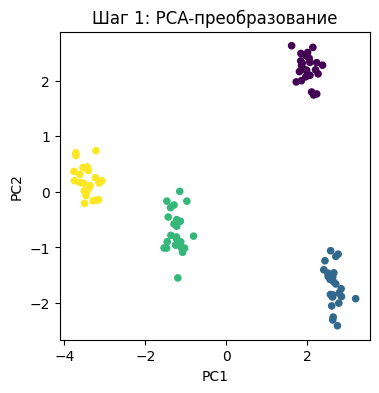

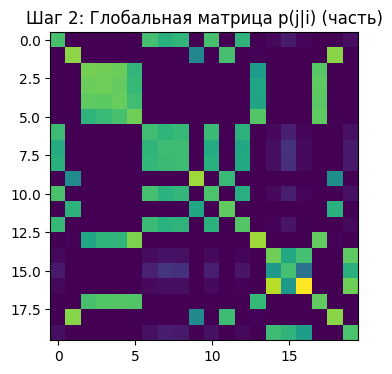

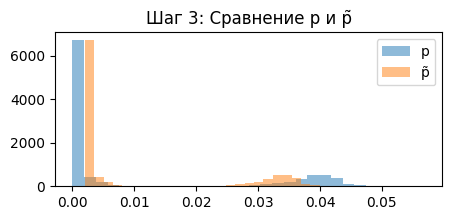

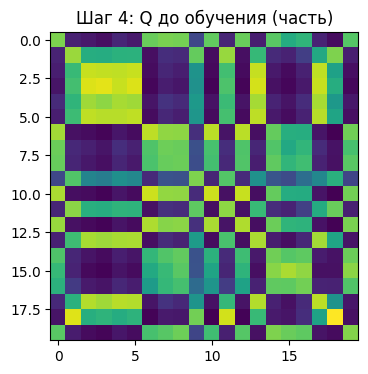

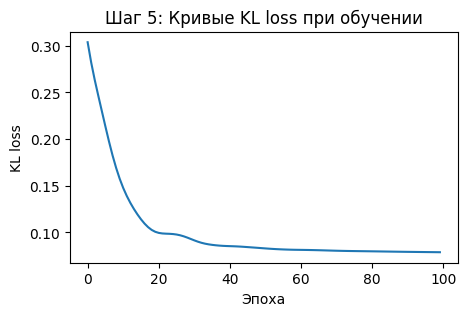

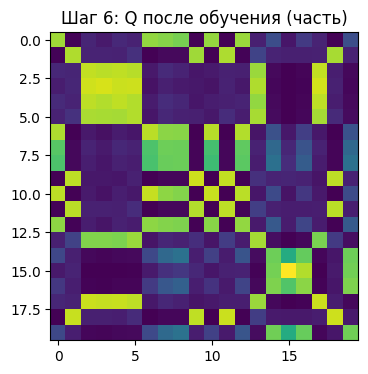

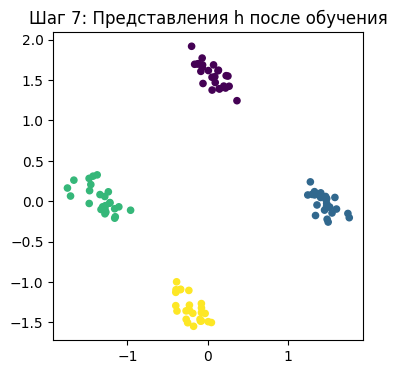

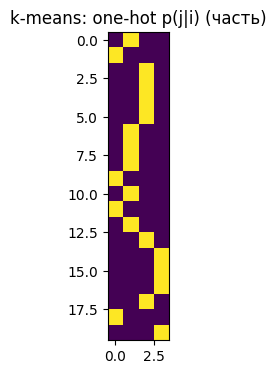

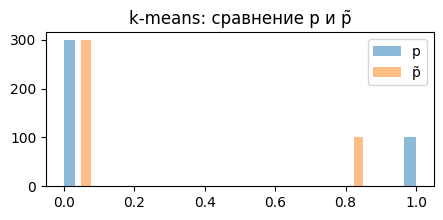

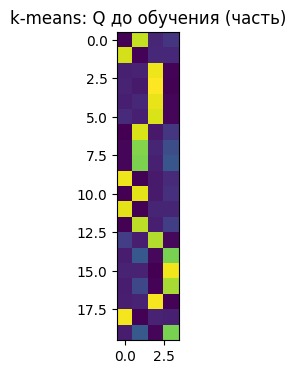

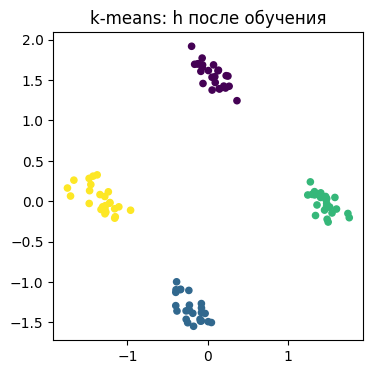

In [13]:
main()